In [66]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")
import sys
sys.path.append("../../semi-supervised")

# Gumbel Softmax

So far we have only seen variational inference with continuous latent variables (the Gaussian distribution), the reason why this was the case is mainly motivated by the fact that we can perform inference using the **reparametrisation trick**, which allows for stochastic backpropogation. In the case of discrete variables, we must instead turn to the **Gumbel softmax trick**.

Similarly to the standard variational autoencoder, we construct the following model:

<img src="../images/gvae.png" width="300px"/>

The difference here is that instead of inferring a continuous latent variable, we replace it with a the categorical variable $y \sim \text{Cat}(k)$. As we shall see, we can use this categorical variable directly as a proxy for the label - avoiding the need to marginalise over all labels.

The main problem we must tackle when working with deep discrete latent variable is how we perform learning. When working with continuous latent variable model, we were able to perform backpropagation through stochastic units using the reparametrisation trick. However, this trick also limited us to a Gaussian base distribution.

Analogous, we have seen how we can use normalising flows to transform an initial Gaussian into almost any other continuous distribution and it turns out, we can do something similar by transforming the Gumbel distribution into a multinomial (categorical) distribution.

The Gumbel cdf is given by:

$$F(x) = \exp(-\exp(-x))$$

Which means we can generate Gumbel noise by transforming uniform noise.

$$G = - \log (- \log u), \ u \sim \mathcal{U}[0, 1]$$

The trick consists of applying the softmax function ($\sigma$) as continuous approximation to a one-hot encoded discrete variable. Where $\tau$ is represents the temperature of the *concrete* distribution of $y$.

$$y = \sigma((x + G)/\tau)$$

Letting $\tau \to 0$, gives us a variable that acts discrete and as such, we want to anneal $\tau$ to $0$ as we train.

For more information on the Gumbel softmax trick, please refer to this [blog post by Gonzalo Mena](https://casmls.github.io/general/2017/02/01/GumbelSoftmax.html)

In [58]:
from models import GumbelAutoencoder

# Latent space dimension should be equal to the number of classes=10
model = GumbelAutoencoder([784, 10, [256, 128]], n_samples=10)
model

GumbelAutoencoder(
  (encoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=784, out_features=256)
      (1): Linear(in_features=256, out_features=128)
    )
  )
  (sampler): GumbelSoftmax(
    (logits): Linear(in_features=128, out_features=100)
  )
  (decoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=128)
      (1): Linear(in_features=128, out_features=256)
      (2): Linear(in_features=256, out_features=784)
    )
  )
)

In [59]:
from datautils import get_mnist

_, train, validation = get_mnist(location="./", batch_size=64)

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [60]:
from torch.autograd import Variable

# Temperature
tau = Variable(torch.FloatTensor([10]), requires_grad=False)

for epoch in range(25):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda(device=0)

        reconstruction = model(u, tau=tau)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data[0]

    # Anneal temperature variable
    m = len(train)
    tau *= 0.7
    
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")

Epoch: 0	L: 234.52
Epoch: 5	L: 174.09
Epoch: 10	L: 158.75
Epoch: 15	L: 153.43
Epoch: 20	L: 152.37


After training, we are able to generate samples by inputting random uniform noise into the decoder.

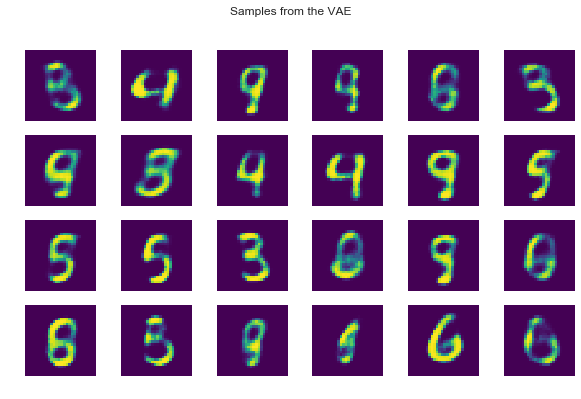

In [71]:
f, axarr = plt.subplots(4, 6, figsize=(10, 6))

x = Variable(torch.rand(64, 10))

reconstruction = model.decoder(x)
r = reconstruction.data.numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Samples from the VAE")
plt.show()

## Latent space

Exploring the latent space of the Gumbel autoencoder, we see that it learns a somewhat reasonable separation of classes without being explicitly trained to do so. Below is a 2d PCA-projection of 256 datapoints on the latent space.

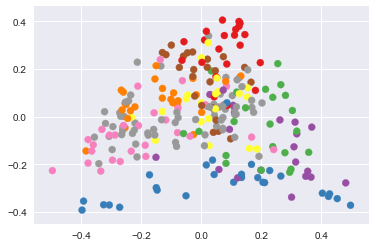

In [74]:
from sklearn.decomposition import PCA

_, _, validation = get_mnist(location="./", batch_size=256)
images, labels = next(iter(validation))
y, _ = model.sampler(model.encoder(Variable(images)))

pca = PCA(2)
projection = pca.fit_transform(y.data.numpy())

plt.scatter(*projection.T, c=np.argmax(labels.numpy(), axis=1), cmap="Set1")
plt.show()

## Semi-supervised learning

This section will follow